In [1]:
import pandas as pd
import psycopg2
import sklearn.model_selection as mod_sel
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as mtx
import matplotlib.pyplot as plt
import pickle as pk

In [2]:
conn = psycopg2.connect(
    host="localhost",
    database="imdb",
    user="postgres",
    password="postgres")

**MARK**

In [3]:
query = '''
select 
    t.titleid,
    t.title,
    r.average_rating,
    r.num_votes,
    b.startyear,
    b.runtimeminutes,
    b.genres
from title t
    inner join rating r on r.titleid = t.titleid
    inner join basics b on b.titleid = t.titleid
where b.titletype like 'movie%'
order by r.num_votes desc, r.average_rating desc
'''

In [4]:
df = pd.read_sql_query(query,con=conn)

In [5]:
df.corr()

,average_rating,num_votes,startyear,runtimeminutes
average_rating,1.000000,0.114442,-0.069517,0.118369
num_votes,0.114442,1.000000,0.092404,0.086815
startyear,-0.069517,0.092404,1.000000,0.173486
runtimeminutes,0.118369,0.086815,0.173486,1.000000


In [6]:
df.describe()

,average_rating,num_votes,startyear,runtimeminutes
count,109781.000000,1.097810e+05,109779.000000,102814.000000
mean,6.072503,4.485496e+03,1973.964729,94.350050
std,1.137369,3.923509e+04,23.347498,30.630023
min,1.000000,5.000000e+00,1903.000000,6.000000
25%,5.400000,2.200000e+01,1957.000000,83.000000
50%,6.200000,8.200000e+01,1977.000000,92.000000
75%,6.900000,4.270000e+02,1994.000000,102.000000
max,9.900000,2.358150e+06,2020.000000,5220.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109781 entries, 0 to 109780
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   titleid         109781 non-null  object 
 1   title           109781 non-null  object 
 2   average_rating  109781 non-null  float64
 3   num_votes       109781 non-null  int64  
 4   startyear       109779 non-null  float64
 5   runtimeminutes  102814 non-null  float64
 6   genres          105663 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 4.6+ MB


**Clean Values**

In [8]:
df = df.dropna()

### **Construir la categoria**

In [9]:
df["class"] = df["average_rating"].apply(lambda x: 'Mala' if x <= 7 else 'Buena')

In [10]:
df.tail(10)

,titleid,title,average_rating,num_votes,startyear,runtimeminutes,genres,class
109767,tt0381208,Gipgo gipeun geugose ...,2.0,5,1985.0,105.0,Crime ...,Mala
109769,tt0024321,En melodi om våren ...,2.0,5,1933.0,83.0,Drama ...,Mala
109770,tt0022040,Kärlek och landstorm ...,1.8,5,1931.0,79.0,Comedy ...,Mala
109771,tt0011281,Help Wanted - Male ...,1.8,5,1920.0,60.0,Comedy ...,Mala
109772,tt0201315,Vitka 'Shushera' i avtomobil ...,1.8,5,1993.0,70.0,Comedy ...,Mala
109774,tt0255866,Le carillon de la liberté ...,1.8,5,1931.0,66.0,Drama ...,Mala
109775,tt0036995,Kärlekslivets offer ...,1.8,5,1944.0,71.0,Drama ...,Mala
109778,tt0190816,Teenager-Report - Die ganz jungen Mädchen ...,1.6,5,1973.0,85.0,Comedy ...,Mala
109779,tt0415349,Varparideh ...,1.6,5,1962.0,100.0,"Drama,Romance ...",Mala
109780,tt0298272,Chueogeui bitt ...,1.4,5,1984.0,103.0,Drama ...,Mala


<AxesSubplot:>

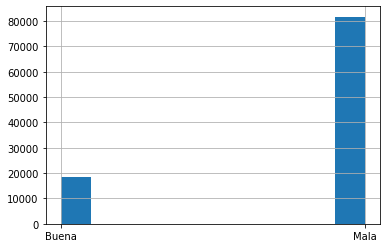

In [11]:
df["class"].hist()

### X e y

In [12]:
X = df[["num_votes","startyear","runtimeminutes"]]
y = df["class"]

### **Separar conjunto de test**

In [13]:
X_train, X_test, y_train, y_test = mod_sel.train_test_split(X, y, random_state=0)
len(X_train)

75152

### **Entrenar**

In [14]:
rfc = RandomForestClassifier(random_state=0)

cv_results = mod_sel.cross_validate(rfc, X_train, y_train, cv=3, 
                                    scoring=["roc_auc"]
                                    , return_train_score=True)

In [15]:
cv_results

{'fit_time': array([14.07488728, 11.88968801,  9.88424993]),
 'score_time': array([2.08035827, 1.18983817, 1.4238894 ]),
 'test_roc_auc': array([0.66491631, 0.66696781, 0.66373782]),
 'train_roc_auc': array([0.99972102, 0.99972421, 0.99975495])}

Result is overfitting. Try GridSearch

In [16]:
params= {"max_depth": [1, 5, 10]}

grid_search = mod_sel.GridSearchCV(rfc, params, cv=3, return_train_score=True,
                                  scoring="roc_auc")

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [1, 5, 10]}, return_train_score=True,
             scoring='roc_auc')

In [17]:
best_model= grid_search.best_estimator_
print(grid_search.best_score_)
print(grid_search.best_params_)
grid_search.cv_results_

0.7172404294471767
{'max_depth': 10}


{'mean_fit_time': array([1.57938552, 3.297815  , 6.94468935]),
 'std_fit_time': array([0.13453508, 0.20158356, 2.34822124]),
 'mean_score_time': array([0.53720522, 0.53183214, 1.39766924]),
 'std_score_time': array([0.1303116 , 0.04547661, 0.88852379]),
 'param_max_depth': masked_array(data=[1, 5, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1}, {'max_depth': 5}, {'max_depth': 10}],
 'split0_test_score': array([0.64011712, 0.70368023, 0.71811157]),
 'split1_test_score': array([0.6361992 , 0.7052957 , 0.71780184]),
 'split2_test_score': array([0.63299019, 0.70018981, 0.71580787]),
 'mean_test_score': array([0.6364355 , 0.70305525, 0.71724043]),
 'std_test_score': array([0.00291435, 0.0021308 , 0.00102083]),
 'rank_test_score': array([3, 2, 1], dtype=int32),
 'split0_train_score': array([0.63709017, 0.71079631, 0.77181482]),
 'split1_train_score': array([0.63582726, 0.70904231, 0.77435432]),
 'split2_train_sc

In [18]:
y_train_pred = best_model.predict(X_train)

In [19]:
print(mtx.confusion_matrix(y_train, y_train_pred))
print(mtx.precision_score(y_train, y_train_pred, pos_label="Buena"))
print(mtx.recall_score(y_train, y_train_pred, pos_label="Buena"))

[[ 2355 11467]
 [  487 60843]]
0.8286418015482054
0.1703805527420055


### **Evaluar**

In [20]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

In [21]:
conf_mat_train = mtx.confusion_matrix(y_train, y_pred_train)
print(conf_mat_train)
print("precision_train: ",round(mtx.precision_score(y_train, y_pred_train, pos_label = "Buena"),2))
print("recall_train: ",round(mtx.recall_score(y_train, y_pred_train, pos_label = "Buena"),2))
print("precision_test: ",round(mtx.precision_score(y_test, y_pred_test, pos_label = "Buena"),2))
print("recall_test: ",round(mtx.recall_score(y_test, y_pred_test, pos_label = "Buena"),2))

[[ 2355 11467]
 [  487 60843]]
precision_train:  0.83
recall_train:  0.17
precision_test:  0.72
recall_test:  0.14


In [22]:
probas_pred = best_model.predict_proba(X_train)

In [23]:
precision, recall, thresholds = mtx.precision_recall_curve(y_train, probas_pred[:,0]
                                                           , pos_label="Buena")

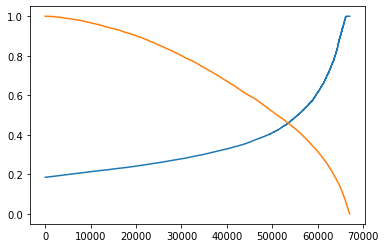

In [24]:
plt.plot(precision)
plt.plot(recall)

### **Save model**

In [25]:
f = open(".\src\mdb_class.pkl", "wb")
pk.dump(best_model, f )